In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import lr_scheduler

from recycle_cnn import CNN
from recycle_pretrained_cnn import PretrainCNN
from recycle_resnet import ResNet, BasicBlock
from collections import Counter


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 0.0001
epochs = 25
batch_size = 32
input_size = 224

In [3]:
trans = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])
train_set = torchvision.datasets.ImageFolder('data/train',transform=trans)

aug_trans1 = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])
aug_trans2 = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])
aug_train_set1 = torchvision.datasets.ImageFolder('data/train', transform=aug_trans1)
aug_train_set2 = torchvision.datasets.ImageFolder('data/train', transform=aug_trans2)

train_all_set = torch.utils.data.ConcatDataset([train_set, aug_train_set1, aug_train_set2])

total = len(train_set)
class_weights = [0] * 6
sample_weights = [0] * len(train_all_set)
for k, i in dict(Counter(train_set.targets)).items():
    class_weights[k] = (total - i) / total
for idx, (data, label) in enumerate(train_all_set):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_all_set, batch_size=batch_size, sampler=sampler)


In [4]:
valid_set = torchvision.datasets.ImageFolder('data/test',transform=trans)
valid_loader = DataLoader(valid_set)

In [5]:
# model = CNN().to(device)
# model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
model = PretrainCNN.to(device)

In [6]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
total_batch = len(train_loader)


In [7]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [9]:
def train_one_epoch(data_loader):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.max(outputs, 1)[1]
        correct += (preds == labels).sum()
        total += len(labels)
        running_loss += loss.detach()
        
    loss = (running_loss / len(data_loader)).item()
    accuracy = (correct * 100 / total).item()
    return loss, accuracy


In [10]:
best_valid_acc = 0

def eval_one_epoch(data_loader):
    global best_valid_acc
    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model.eval()
    running_loss = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]
            correct += (preds == labels).sum()
            
            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            total += len(labels)
            running_loss += loss.detach()
        
        loss = (running_loss / len(data_loader)).item()
        accuracy = (correct * 100 / total).item()
        if accuracy > best_valid_acc:
            torch.save(model, 'best_model.pt')
        return loss, accuracy, correct_pred, total_pred

In [11]:
train_loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = [] 
valid_class_acc_hist = {classname: [] for classname in classes}

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(train_loader)
    exp_lr_scheduler.step() # learning rate를 step마다 조절해준다.
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    valid_loss, valid_acc, correct_pred, total_pred = eval_one_epoch(valid_loader)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    print(f"Epoch: {epoch}\nTrain Loss: {train_loss_hist[-1]}, accuracy: {train_acc_hist[-1]}\n"+
        f"Valid loss: {valid_loss_hist[-1]}, accuracy: {valid_acc_hist[-1]}")
    
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        valid_class_acc_hist[classname].append(accuracy)
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Epoch: 0
Train Loss: 0.7245974540710449, accuracy: 73.45738220214844
Valid loss: 0.63657546043396, accuracy: 78.19025421142578
Accuracy for class: cardboard is 91.4 %
Accuracy for class: glass is 90.2 %
Accuracy for class: metal is 66.2 %
Accuracy for class: paper is 89.8 %
Accuracy for class: plastic is 53.4 %
Accuracy for class: trash is 60.0 %
Epoch: 1
Train Loss: 0.3239213824272156, accuracy: 88.59732818603516
Valid loss: 0.5453550219535828, accuracy: 81.20649719238281
Accuracy for class: cardboard is 95.7 %
Accuracy for class: glass is 67.1 %
Accuracy for class: metal is 88.2 %
Accuracy for class: paper is 77.8 %
Accuracy for class: plastic is 82.2 %
Accuracy for class: trash is 80.0 %
Epoch: 2
Train Loss: 0.20940960943698883, accuracy: 92.60496520996094
Valid loss: 0.535342812538147, accuracy: 85.84686279296875
Accuracy for class: cardboard is 88.6 %
Accuracy for class: glass is 89.0 %
Accuracy for class: metal is 76.5 %
Accuracy for class: paper is 90.7 %
Accuracy for class: pla

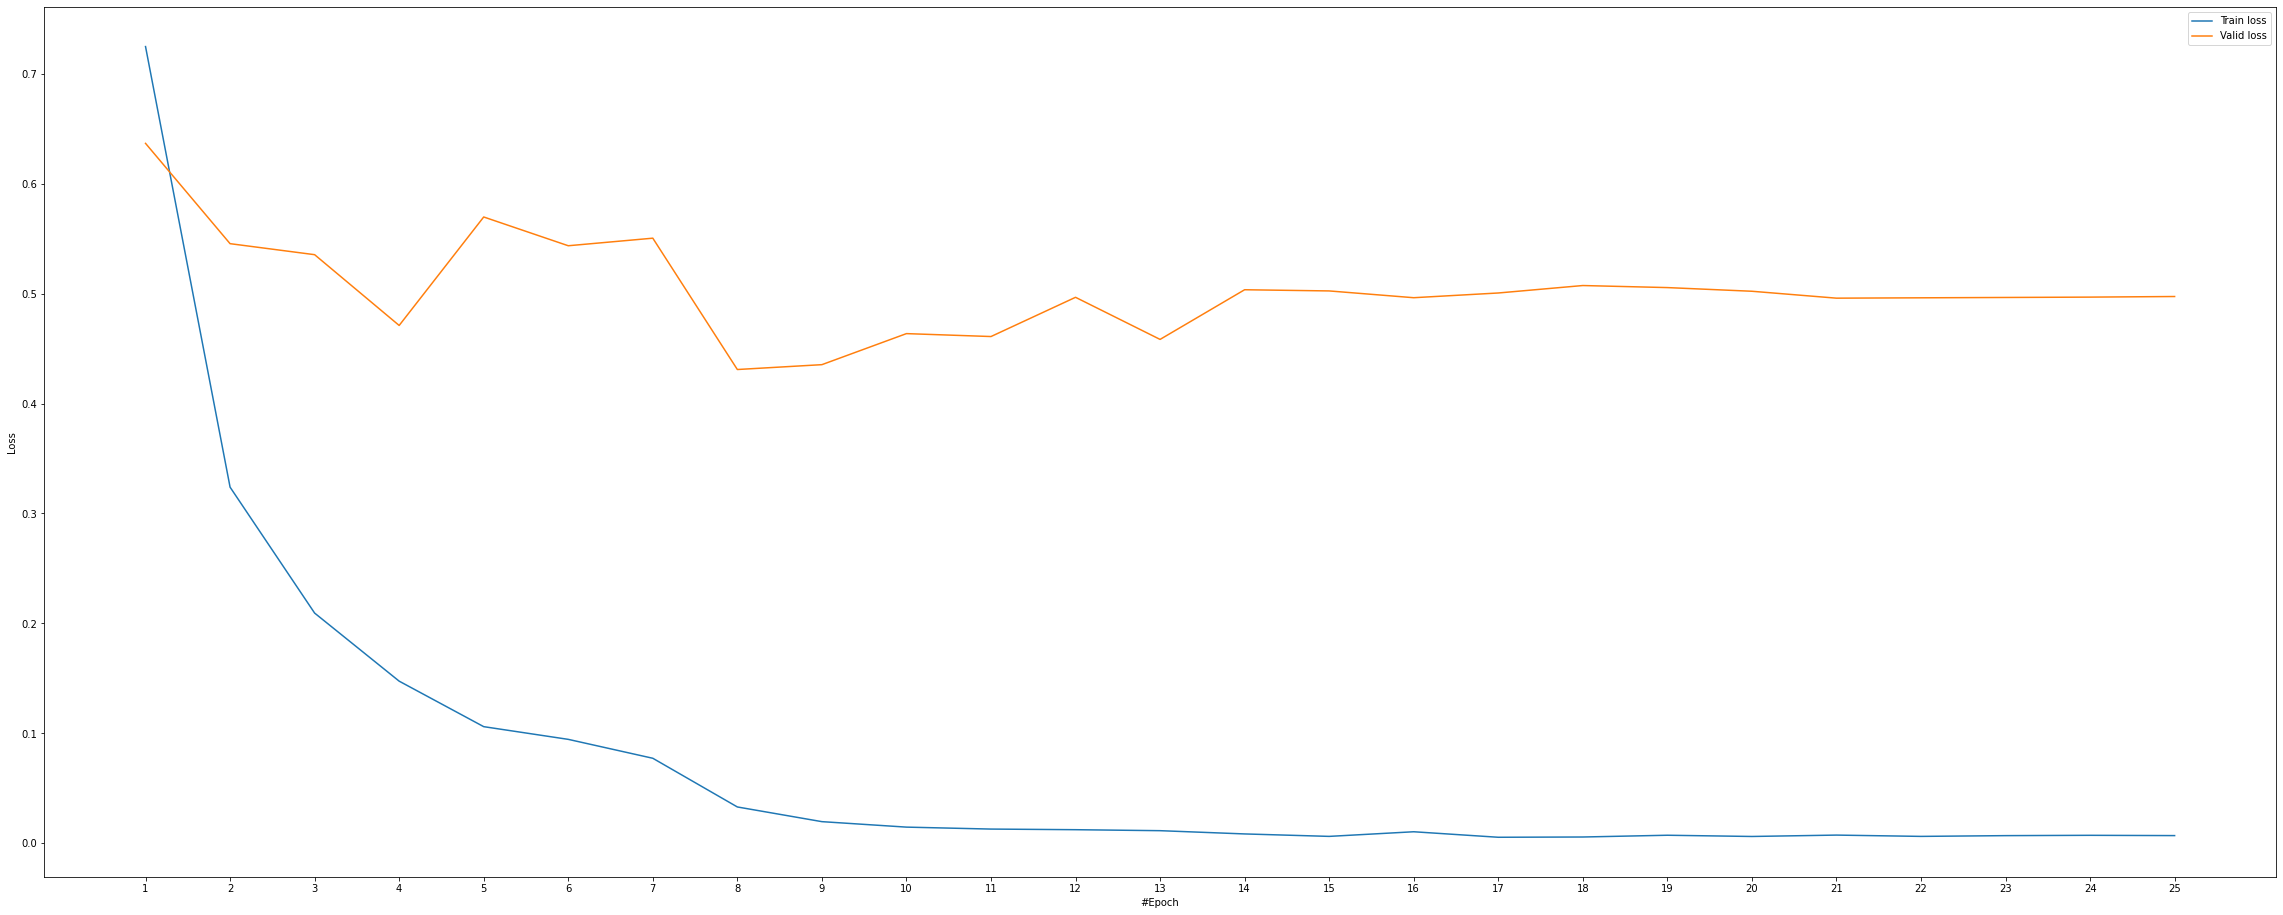

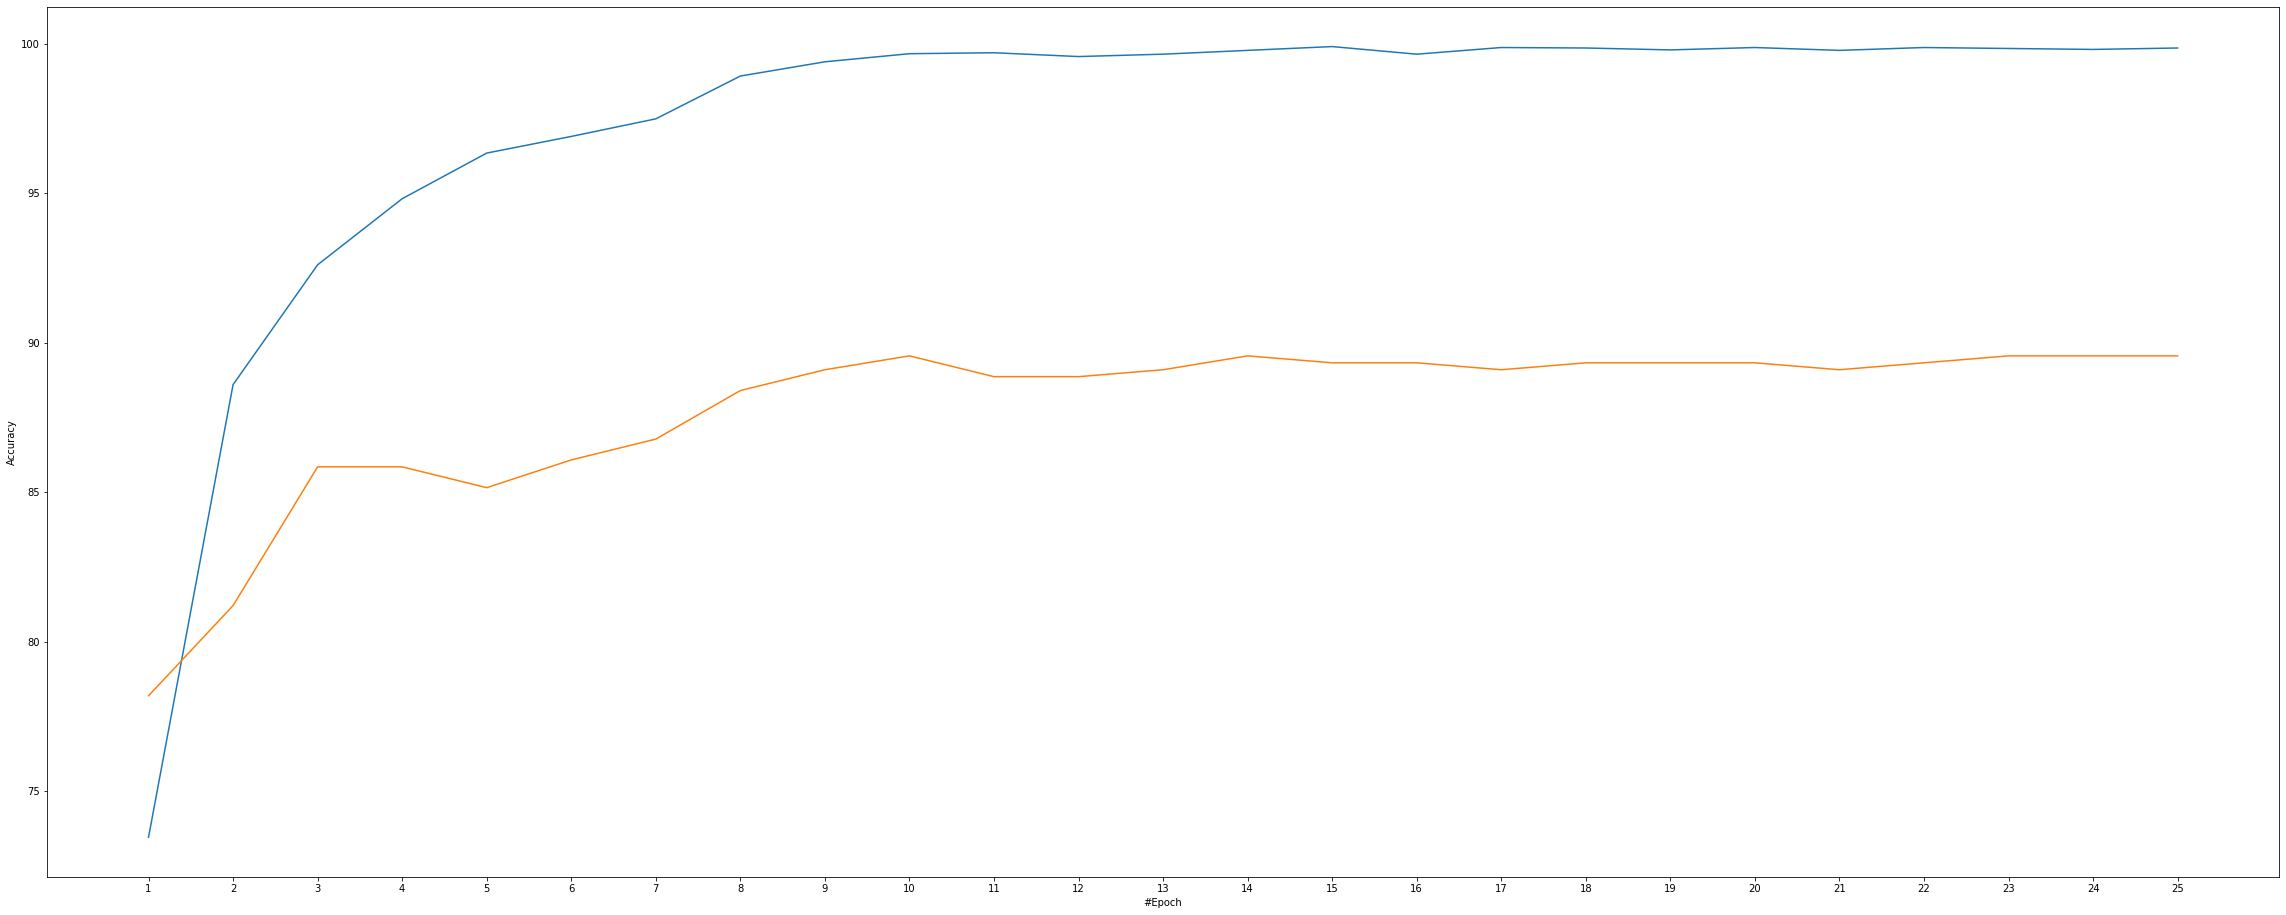

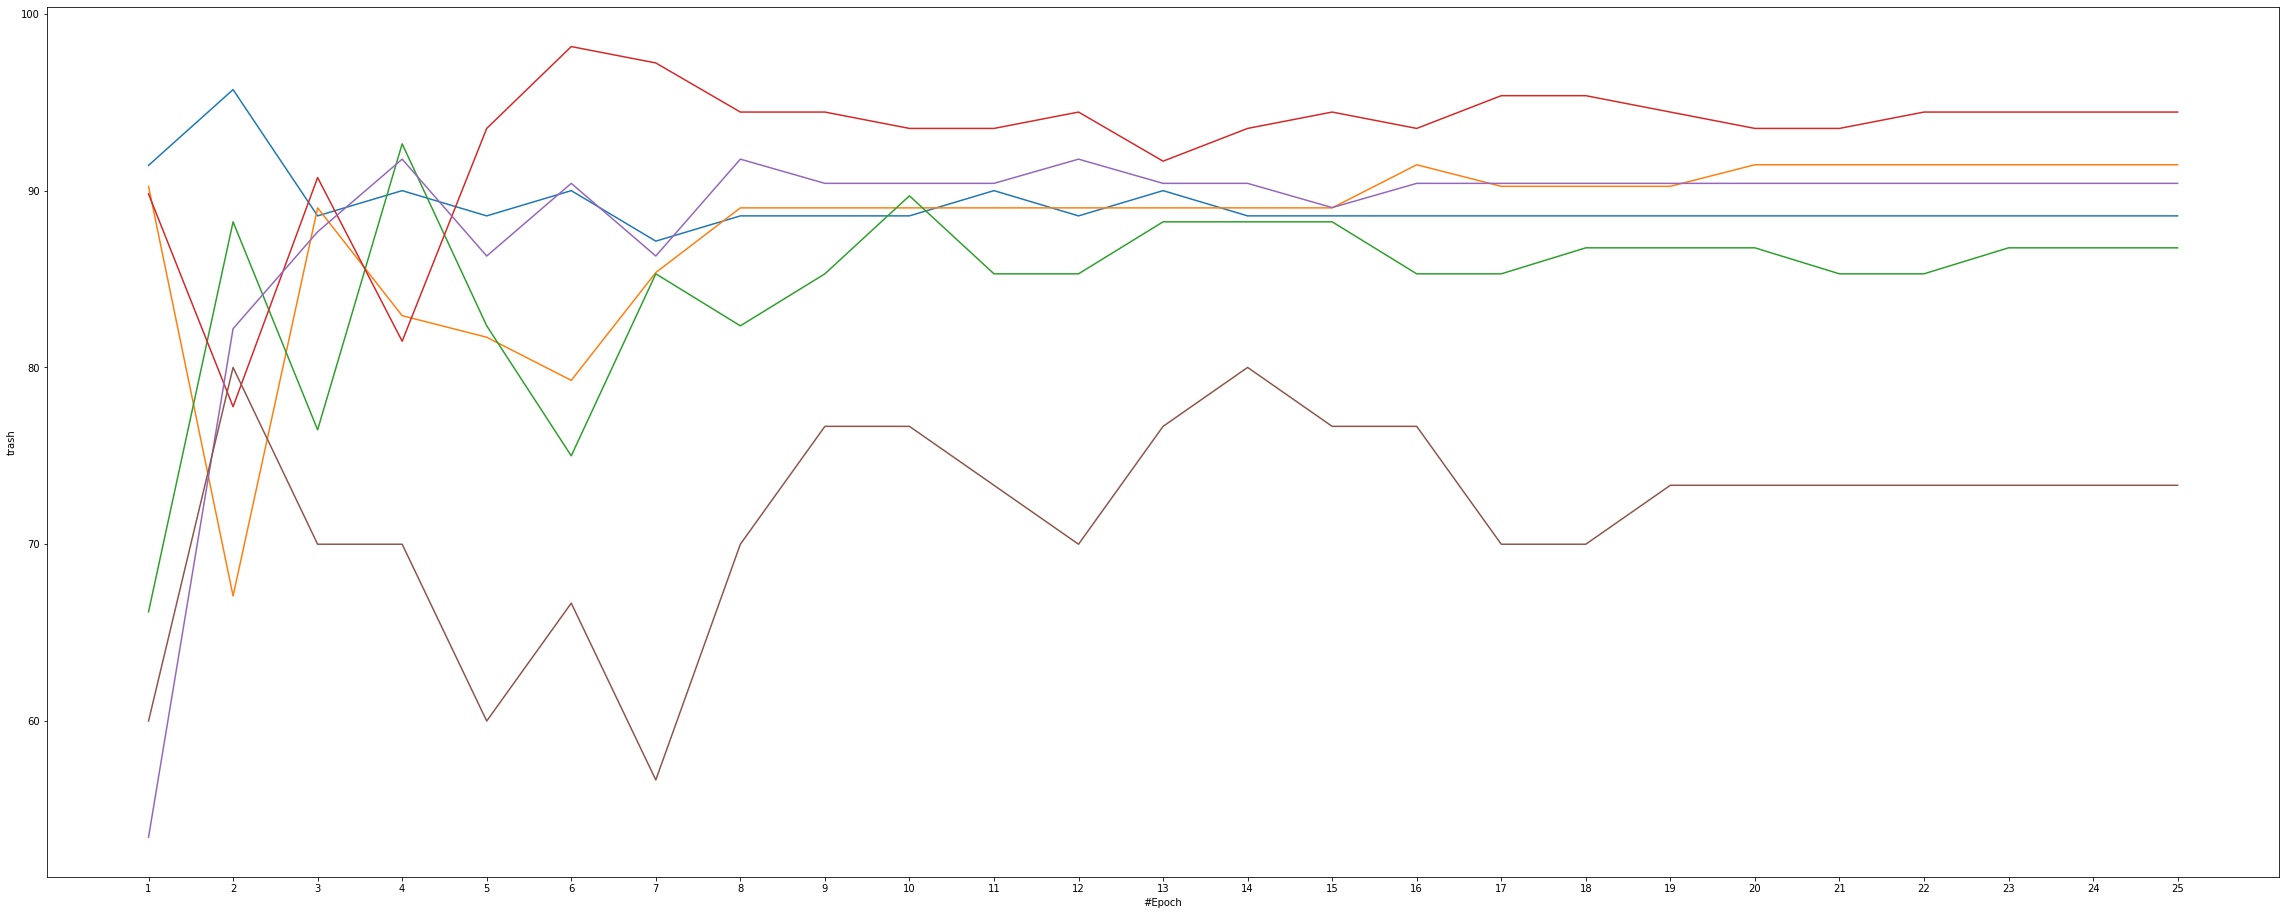

In [12]:
epochs = list(range(1, epochs + 1))
plt.figure(figsize=(40, 16))
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure(figsize=(40, 16))
plt.plot(epochs, train_acc_hist, label='Train accuracy')
plt.plot(epochs, valid_acc_hist, label='Valid accuracy')
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.show()

plt.figure(figsize=(40, 16))
for classname, accuracy in valid_class_acc_hist.items():
    plt.plot(epochs, accuracy, label='%s accuracy' % classname)
    plt.xlabel("#Epoch")
    plt.ylabel(classname)
    plt.xticks(epochs)
plt.show()



In [13]:
torch.save(model, 'model.pt')